In [162]:
import numpy as np
import pandas as pd
import patsy
import itertools

from sklearn.linear_model import (Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, 
                     MultiTaskLassoCV, LassoCV, ElasticNetCV,  SGDRegressor, SGDClassifier)

from sklearn import grid_search, datasets

import datetime

from ipywidgets import *
from IPython.display import display

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Exercise 1

In the "IAValues" dataset, there are a number of missing (null) values for the rootznaws column, which measures root zone available water storage.  The goal of this challenge is to create a simple model to predict those missing values.
Load the dataset and perform and appropriate inspection of the data to verify that it is suitable for building a model.

Build a model (please explain your choice of model and why you choose it over alternatives) to predict the value of rootznaws.

Use your model to predict the missing values of rootznaws.

Analyze/discuss the accuracy of your model and any potential improvements you'd make on it given more time.


In [163]:
iavalues = pd.read_csv("IAValues_updated_v2.cvs")

In [164]:
iavalues.tail()

,Unnamed: 0,Unnamed: 0.1,mukey,OBJECTID_1,tk0_5a,tk5_20a,tk20_50a,tk50_100a,tk100_150a,tk150_999a,...,nccpi2cs,nccpi2sg,nccpi2co,nccpi2all,pctearthmc,rootznemc,rootznaws,droughty,pwsl1pomu,musumcpct
10796,10796,10796,408523,55089,5.0,15.0,30.0,50.0,50.0,2.000000,...,0.41,0.35,0.00,0.41,100,150,179.0,0,100,100
10797,10797,10797,408524,55040,5.0,15.0,30.0,50.0,50.0,2.000000,...,0.75,0.55,0.00,0.75,100,150,211.0,0,100,100
10798,10798,10798,408525,55105,5.0,15.0,30.0,50.0,50.0,2.000000,...,0.92,0.78,0.09,0.92,100,150,301.0,0,0,100
10799,10799,10799,408526,55052,5.0,15.0,30.0,50.0,50.0,2.000000,...,0.91,0.76,0.00,0.91,90,150,322.0,0,0,100
10800,10800,10800,408527,55006,5.0,15.0,30.0,50.0,50.0,32.599998,...,0.56,0.42,0.00,0.56,100,137,213.0,0,0,100


In [165]:
iavalues.head()

,Unnamed: 0,Unnamed: 0.1,mukey,OBJECTID_1,tk0_5a,tk5_20a,tk20_50a,tk50_100a,tk100_150a,tk150_999a,...,nccpi2cs,nccpi2sg,nccpi2co,nccpi2all,pctearthmc,rootznemc,rootznaws,droughty,pwsl1pomu,musumcpct
0,0,0,1601875,55642,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,100,0,0.0,1,0,100
1,1,1,1601876,55643,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,100,0,0.0,1,0,100
2,2,2,1601877,55584,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,NaN,0,0,100
3,3,3,1601878,55622,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,NaN,0,999,100
4,4,4,1601879,55652,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0,0,0.0,0,0,100


In [166]:
iavalues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10801 entries, 0 to 10800
Data columns (total 49 columns):
Unnamed: 0      10801 non-null int64
Unnamed: 0.1    10801 non-null int64
mukey           10801 non-null int64
OBJECTID_1      10801 non-null int64
tk0_5a          10801 non-null float64
tk5_20a         10801 non-null float64
tk20_50a        10801 non-null float64
tk50_100a       10801 non-null float64
tk100_150a      10801 non-null float64
tk150_999a      10801 non-null float64
tk0_20a         10801 non-null float64
tk0_30a         10801 non-null float64
tk0_100a        10801 non-null float64
tk0_150a        10801 non-null float64
tk0_999a        10801 non-null float64
musumcpcta      10801 non-null int64
soc0_5          10801 non-null float64
soc5_20         10801 non-null float64
soc20_50        10801 non-null float64
soc50_100       10801 non-null float64
soc100_150      10801 non-null float64
soc150_999      10801 non-null float64
soc0_20         10801 non-null float64
soc0

In [167]:
iavalues.rename(columns={'Unnamed: 0':'Column0'}, inplace=True)

In [168]:
iavalues.rename(columns={'Unnamed: 1':'Column1'}, inplace=True)

In [169]:
iavalues.rename(columns={'Unnamed: 0.1':'Column01'}, inplace=True)

Clean up names of these columns so patsy can deal w them later.

I will do a regression using variable "rootznaws" as my target, and the other variables as the dependent variables. 

In [170]:
iavalues_corr = iavalues.corr()

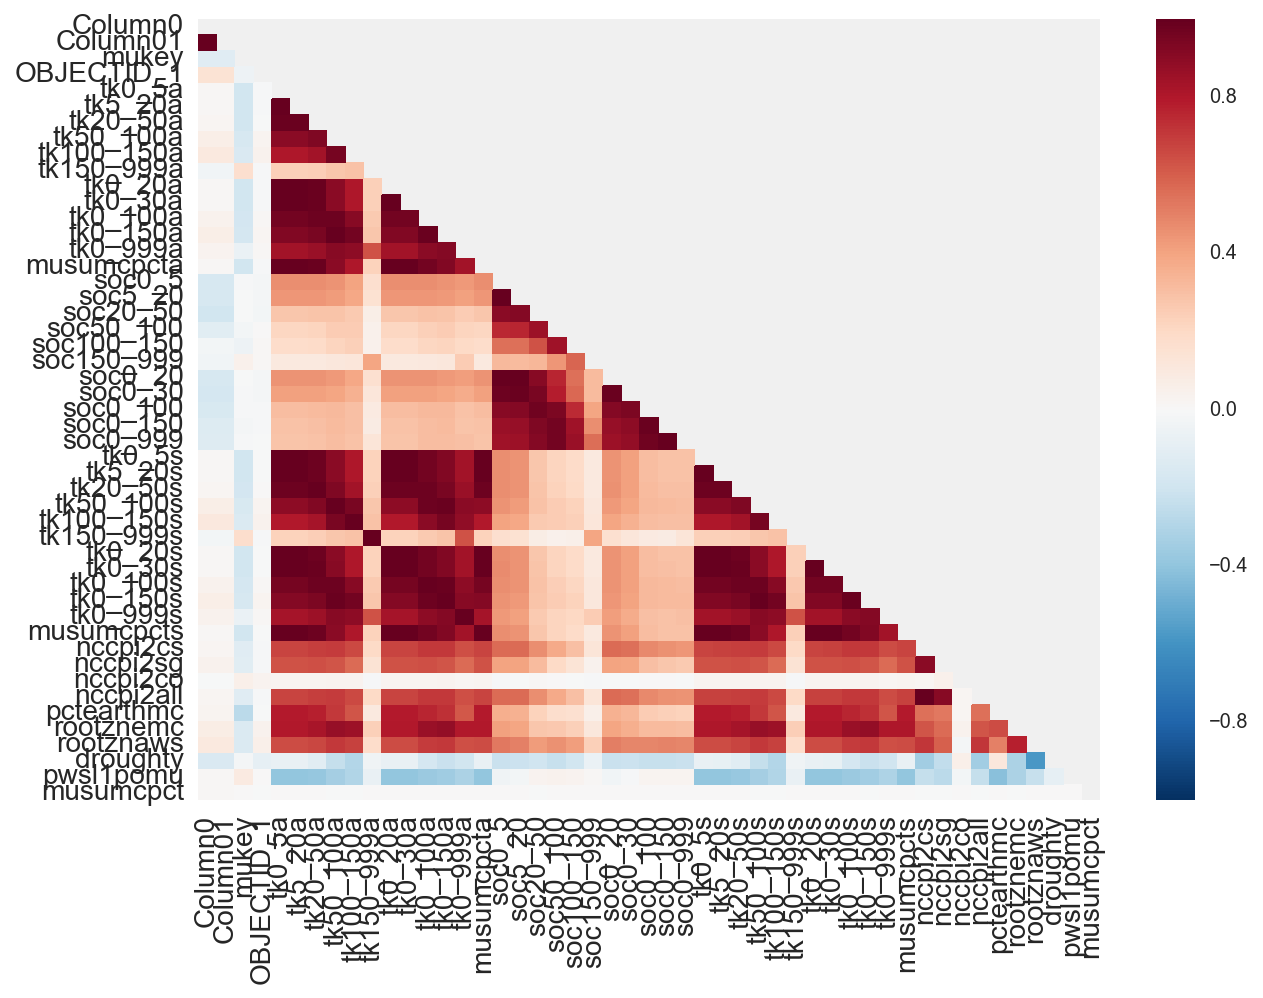

In [171]:
plt.rcParams['figure.figsize']=(9,7)

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(iavalues_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(iavalues_corr, mask=mask)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

This auto-correlation map show stron correlation between some vars. 

I will to a Ridge regression, to see which are the dependent vars, with 'rootznaws' 
the independent var.

In [172]:
target="rootznaws"

In [173]:
import patsy

# Get the non-target cols with a simple list comprehension
non_target_cols = [x for x in iavalues.columns if x != target]

# Use some string adding and joining to make the simple model formula:
# put in -1 to remove the intercept (which sklearn will add later on)
formula_simple = target + ' ~ ' + ' + '.join(non_target_cols) + ' -1'
print formula_simple

# Create the X and Y pairs for our data
Y, X = patsy.dmatrices(formula_simple, data=iavalues)

rootznaws ~ Column0 + Column01 + mukey + OBJECTID_1 + tk0_5a + tk5_20a + tk20_50a + tk50_100a + tk100_150a + tk150_999a + tk0_20a + tk0_30a + tk0_100a + tk0_150a + tk0_999a + musumcpcta + soc0_5 + soc5_20 + soc20_50 + soc50_100 + soc100_150 + soc150_999 + soc0_20 + soc0_30 + soc0_100 + soc0_150 + soc0_999 + tk0_5s + tk5_20s + tk20_50s + tk50_100s + tk100_150s + tk150_999s + tk0_20s + tk0_30s + tk0_100s + tk0_150s + tk0_999s + musumcpcts + nccpi2cs + nccpi2sg + nccpi2co + nccpi2all + pctearthmc + rootznemc + droughty + pwsl1pomu + musumcpct -1


In [174]:
def ridge_coefs(X, Y, alphas):
    
    # set up the list to hold the different sets of coefficients:
    coefs = []
    
    # Set up a ridge regression object
    ridge_reg = Ridge()
    
    # Iterate through the alphas fed into the function:
    for a in alphas:
        
        # On each alpha reset the ridge model's alpha to the current one:
        ridge_reg.set_params(alpha=a)
        
        # fit or refit the model on the provided X, Y
        ridge_reg.fit(X, Y)
        
        # Get out the coefficient list (first element of the .coef_ attribute)
        coefs.append(ridge_reg.coef_[0])
        
    return coefs

In [175]:
r_alphas = np.logspace(0, 5, 200)

# Get the coefficients for each alpha for the Ridge, using the function above
r_coefs = ridge_coefs(X, Y, r_alphas)

In [176]:
from cycler import cycler

def coef_plotter(alphas, coefs, feature_names, to_alpha, regtype='ridge'):
    
    # Get the full range of alphas before subsetting to keep the plots from 
    # resetting axes each time. (We use these values to set static axes later).
    amin = np.min(alphas)
    amax = np.max(alphas)
    
    # Subset the alphas and coefficients to just the ones below the set limit
    # from the interactive widget:
    alphas = [a for a in alphas if a <= to_alpha]
    coefs = coefs[0:len(alphas)]
    
    # Get some colors from seaborn:
    colors = sns.color_palette("husl", len(coefs[0]))
    
    # Get the figure and reset the size to be wider:
    fig = plt.figure()
    fig.set_size_inches(18,7)

    # We have two axes this time on our figure. 
    # The fig.add_subplot adds axes to our figure. The number inside stands for:
    #[figure_rows|figure_cols|position_of_current_axes]
    ax1 = fig.add_subplot(121)
    
    # Give it the color cycler:
    ax1.set_prop_cycle(cycler('color', colors))
    
    # Print a vertical line showing our current alpha threshold:
    ax1.axvline(to_alpha, lw=2, ls='dashed', c='k', alpha=0.4)
    
    # Plot the lines of the alphas on x-axis and coefficients on y-axis
    ax1.plot(alphas, coefs, lw=2)
    
    # set labels for axes:
    ax1.set_xlabel('alpha', fontsize=20)
    ax1.set_ylabel('coefficients', fontsize=20)
    
    # If this is for the ridge, set this to a log scale on the x-axis:
    if regtype == 'ridge':
        ax1.set_xscale('log')
    
    # Enforce the axis limits:
    ax1.set_xlim([amin, amax])
    
    # Put a title on the axis
    ax1.set_title(regtype+' coef paths\n', fontsize=20)
    
    # Get the ymin and ymax for this axis to enforce it to be the same on the 
    # second chart:
    ymin, ymax = ax1.get_ylim()

    # Add our second axes for the barplot in position 2:
    ax2 = fig.add_subplot(122)
    
    # Position the bars according to their index from the feature names variable:
    ax2.bar(range(1, len(feature_names)+1), coefs[-1], align='center', color=colors)
    ax2.set_xticks(range(1, len(feature_names)+1))
    
    # Reset the ticks from numbers to acutally be the names:
    ax2.set_xticklabels(feature_names, rotation=65, fontsize=12)
    
    # enforce limits and add titles, labels
    ax2.set_ylim([ymin, ymax])
    ax2.set_title(regtype+' predictor coefs\n', fontsize=20)
    ax2.set_xlabel('coefficients', fontsize=20)
    ax2.set_ylabel('alpha', fontsize=20)
    
    plt.show()

In [177]:
simple_feature_names = X.design_info.column_names

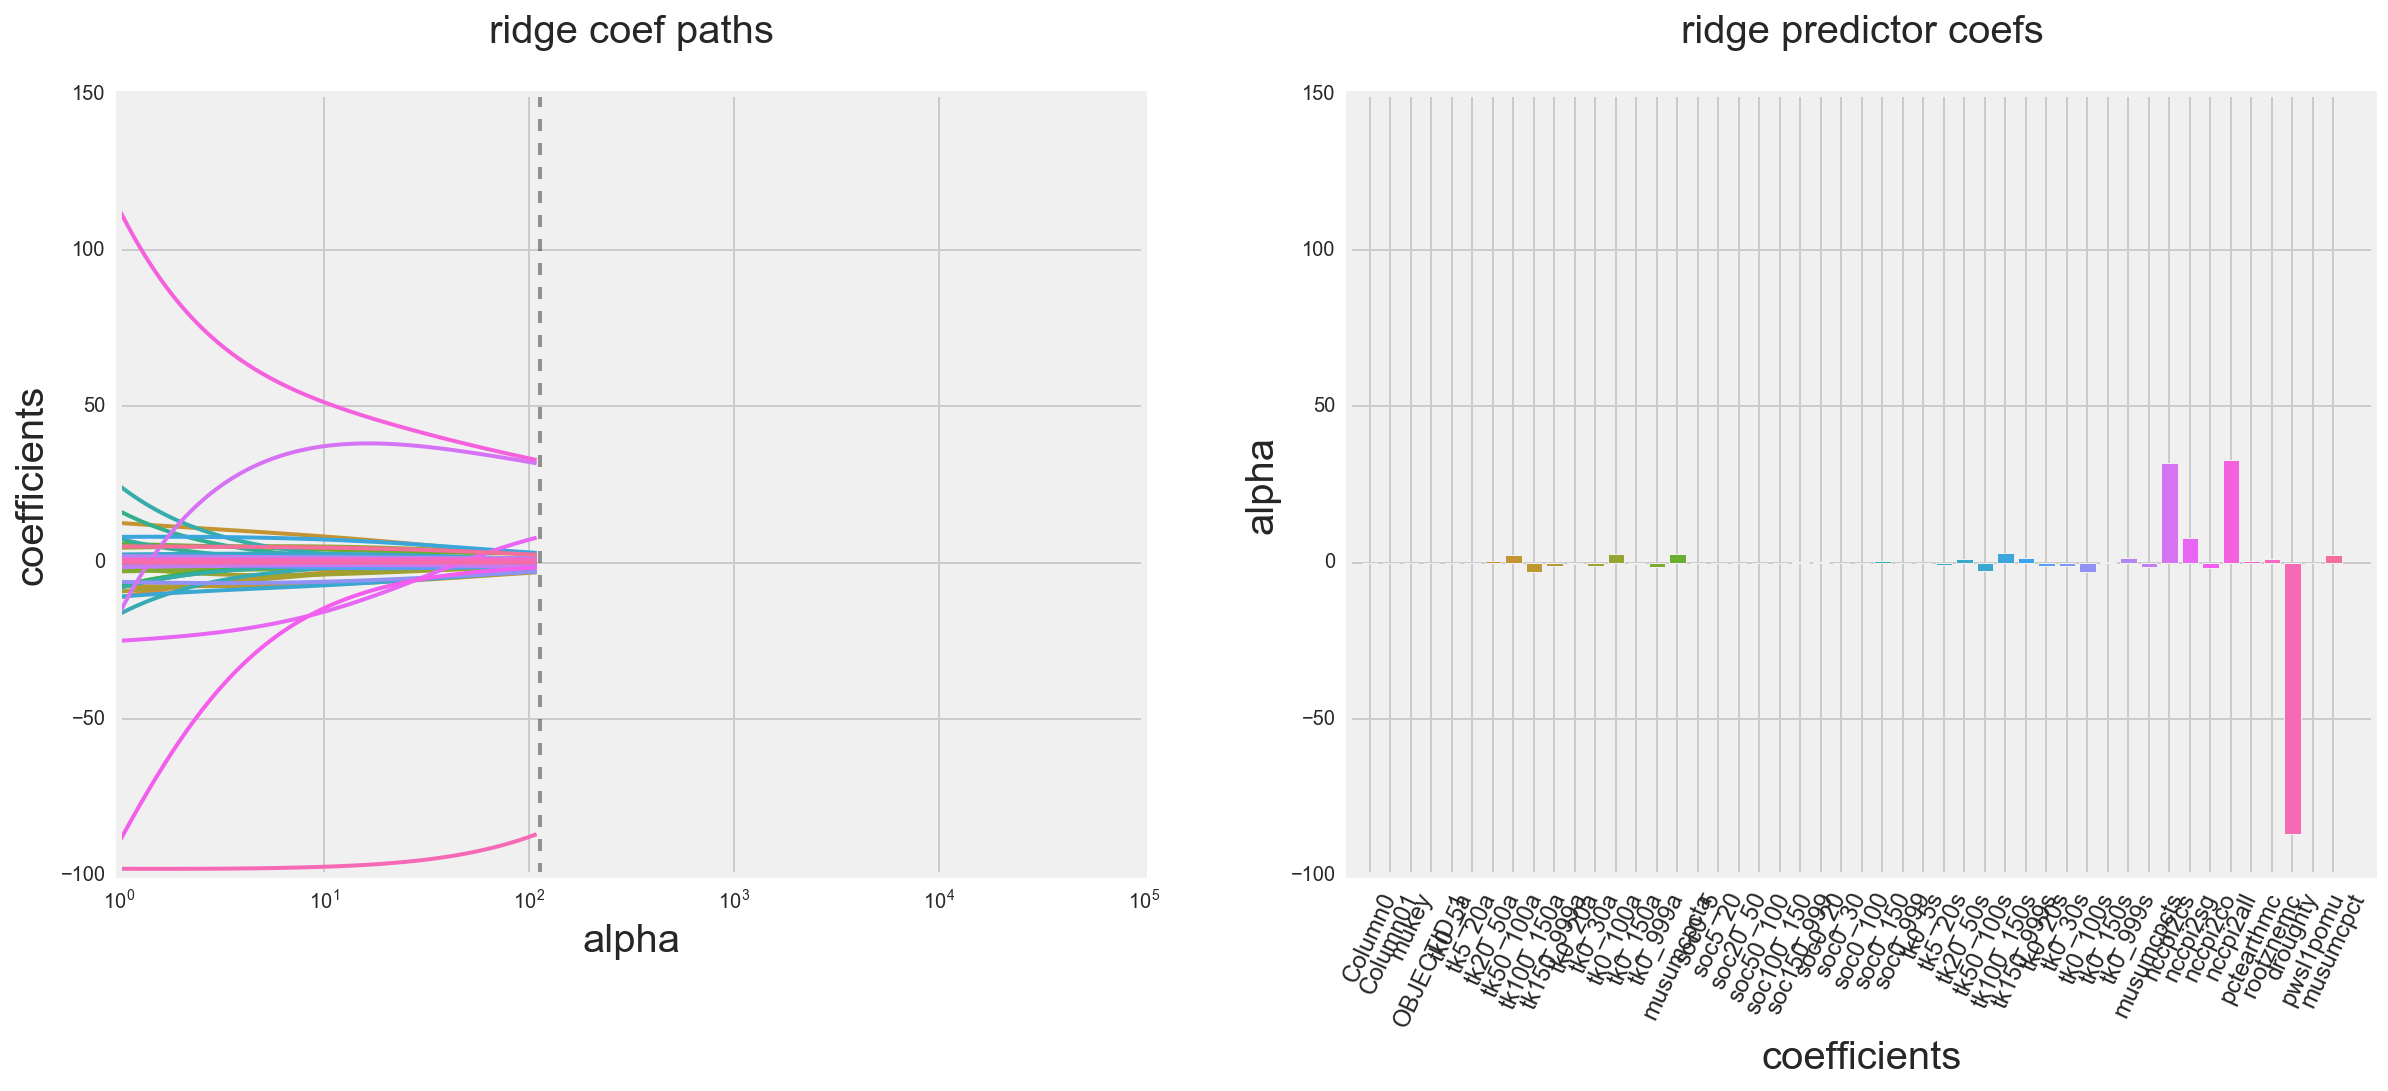

In [178]:
def ridge_plot_runner(log_of_alpha=7):
    coef_plotter(r_alphas, r_coefs, simple_feature_names, 10**log_of_alpha, regtype='ridge')

interact(ridge_plot_runner, log_of_alpha=(0.0,5.0,0.05))

Based on this very quick analysis,it seems that 'rootznaws' correlates stronger w 'musumcpcta', 'nccpi2co', and anti-correlates strongly w 'rootznemc'. There are some other vars, but seem less significant.